Training accuracy: 99.04306220095694 %
Test accuracy: 70.0 %


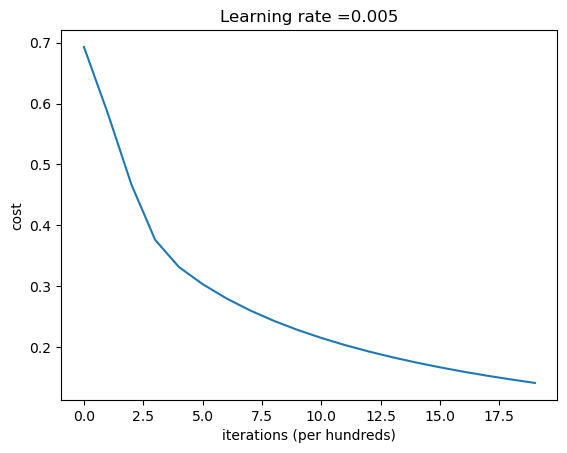

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Load the datasets
def load_dataset():
    train_dataset = h5py.File('train_catvnoncat.h5', "r")
    test_dataset = h5py.File('test_catvnoncat.h5', "r")

    # Extract train and test datasets
    train_set_x_orig = np.array(train_dataset["train_set_x"][:])  # Training data
    train_set_y_orig = np.array(train_dataset["train_set_y"][:])  # Training labels

    test_set_x_orig = np.array(test_dataset["test_set_x"][:])     # Test data
    test_set_y_orig = np.array(test_dataset["test_set_y"][:])     # Test labels

    # Reshape labels
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))

    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig

# Sigmoid activation function
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Initialize weights and bias
def initialize_weights(dim):
    w = np.zeros((dim, 1))
    b = 0
    return w, b

# Compute forward and backward propagation
def propagate(w, b, X, Y):
    m = X.shape[1]

    # Forward propagation
    A = sigmoid(np.dot(w.T, X) + b)  # Compute activation
    cost = -1/m * np.sum(Y * np.log(A) + (1 - Y) * np.log(1 - A))  # Compute cost

    # Backward propagation
    dw = 1/m * np.dot(X, (A - Y).T)
    db = 1/m * np.sum(A - Y)

    cost = np.squeeze(cost)
    grads = {"dw": dw, "db": db}

    return grads, cost

# Optimize weights using gradient descent
def optimize(w, b, X, Y, num_iterations, learning_rate):
    costs = []

    for i in range(num_iterations):
        grads, cost = propagate(w, b, X, Y)
        dw = grads["dw"]
        db = grads["db"]

        # Update weights and bias
        w = w - learning_rate * dw
        b = b - learning_rate * db

        # Record the cost every 100 iterations
        if i % 100 == 0:
            costs.append(cost)

    params = {"w": w, "b": b}
    grads = {"dw": dw, "db": db}

    return params, grads, costs

# Predict using learned weights and bias
def predict(w, b, X):
    A = sigmoid(np.dot(w.T, X) + b)
    Y_prediction = (A > 0.5).astype(int)
    return Y_prediction

# Model function to tie everything together
def model(X_train, Y_train, X_test, Y_test, num_iterations=2000, learning_rate=0.005):
    w, b = initialize_weights(X_train.shape[0])
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate)

    # Retrieve final parameters
    w = parameters["w"]
    b = parameters["b"]

    # Make predictions
    Y_prediction_train = predict(w, b, X_train)
    Y_prediction_test = predict(w, b, X_test)

    # Print training and test accuracies
    print("Training accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("Test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    # Output dictionary
    d = {
        "costs": costs,
        "Y_prediction_train": Y_prediction_train,
        "Y_prediction_test": Y_prediction_test,
        "w": w,
        "b": b,
        "learning_rate": learning_rate,
        "num_iterations": num_iterations
    }

    return d

# Load the dataset
train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig = load_dataset()

# Flatten and standardize the data
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T / 255.
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T / 255.

# Train the model
d = model(train_set_x_flatten, train_set_y_orig, test_set_x_flatten, test_set_y_orig, num_iterations=2000, learning_rate=0.005)

# Plot cost function over iterations
plt.plot(d["costs"])
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.savefig("results/cost_vs_iterations.png", dpi=300, bbox_inches='tight')
plt.show()

Original Dataset - Train Accuracy: 0.8812
Original Dataset - Test Accuracy: 0.5918
Misclassified images: 20


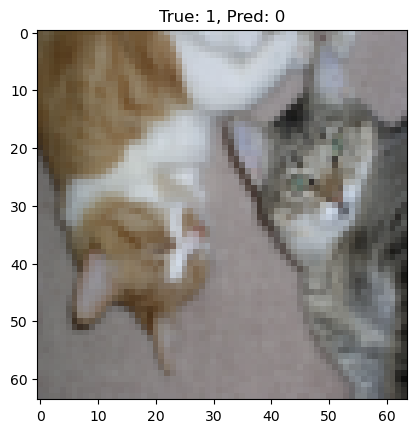

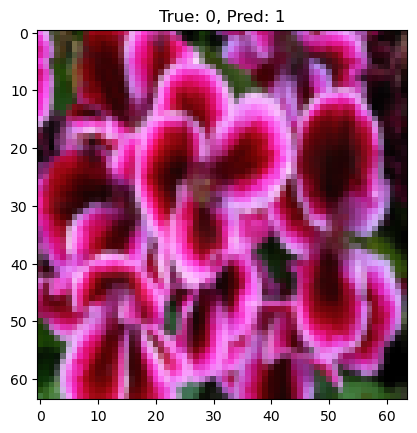

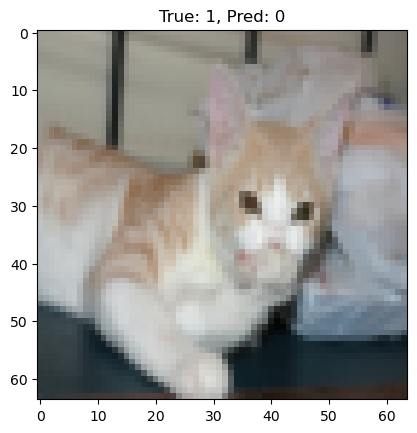

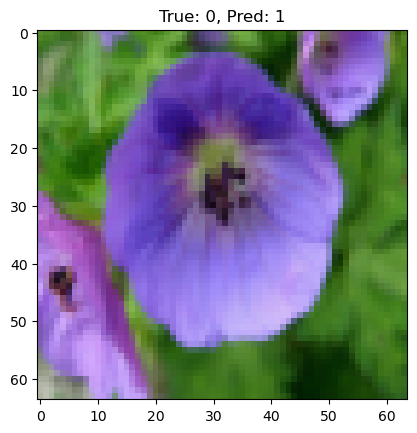

In [3]:
# Now, I repeat the whole process for printing the misclassified images.

# Load the dataset
def load_dataset(file_path):
    with h5py.File(file_path, 'r') as f:
        X = np.array(f['train_set_x'][:])  # Images
        y = np.array(f['train_set_y'][:])  # Labels
    return X, y

# Preprocess the data (flatten and normalize)
def preprocess_data(X, y):
    X = X / 255.0  # Normalize
    X = X.reshape(X.shape[0], -1)  # Flatten
    y = np.where(y == 1, 1, 0)  # Ensure binary labels
    return X, y

# Logistic Regression Class
class LogisticRegression:
    def __init__(self, learning_rate=0.01, num_iterations=1000):
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations
        self.theta = None

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        m, n = X.shape
        self.theta = np.zeros(n)
        
        for _ in range(self.num_iterations):
            predictions = self.sigmoid(np.dot(X, self.theta))
            error = predictions - y
            gradient = (1 / m) * np.dot(X.T, error)
            self.theta -= self.learning_rate * gradient

    def predict(self, X):
        predictions = self.sigmoid(np.dot(X, self.theta))
        return (predictions >= 0.5).astype(int)

    def accuracy(self, X, y):
        return np.mean(self.predict(X) == y)

# Display misclassified images
def display_misclassified_images(X, y, model, misclassified_indices):
    i=0
    for idx in misclassified_indices[:4]:
        plt.imshow(X[idx].reshape(64, 64, 3))
        plt.title(f"True: {y[idx]}, Pred: {model.predict(X[idx].reshape(1, -1))[0]}")
        path = f"results/image{i}.png"
        plt.savefig(path, dpi=300, bbox_inches='tight')
        i+=1
        plt.show()

# Train and evaluate model
def train_and_evaluate(X_train, y_train, X_test, y_test, modified):
    model = LogisticRegression(learning_rate=0.001, num_iterations=1000)
    model.fit(X_train, y_train)

    train_acc = model.accuracy(X_train, y_train)
    test_acc = model.accuracy(X_test, y_test)
    print(f"{'Modified' if modified else 'Original'} Dataset - Train Accuracy: {train_acc:.4f}")
    print(f"{'Modified' if modified else 'Original'} Dataset - Test Accuracy: {test_acc:.4f}")

    misclassified_indices = np.where(model.predict(X_test) != y_test)[0]
    print(f"Misclassified images: {len(misclassified_indices)}")
    display_misclassified_images(X_test, y_test, model, misclassified_indices)

# Main program
if __name__ == "__main__":
    file_path = 'train_catvnoncat.h5'
    X, y = load_dataset(file_path)
    X, y = preprocess_data(X, y)

    num_train = 160

    # Split dataset based on student ID
    X_train = X[:num_train]
    y_train = y[:num_train]
    X_test = X[num_train:]
    y_test = y[num_train:]

    # Train and evaluate on the modified dataset
    train_and_evaluate(X_train, y_train, X_test, y_test, modified=False)
